## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

When a job is submitted to ACCRE, it goes through the slurm scheduler, which tracks and manages compute and memory resources. It is hypothesized that the slurm scheduler is processing so many job completions so frequently that it sometimes becomes unresponsive to commands from users trying to schedule new jobs or check job status. This is a particularly bad problem for clients who use automated submission systems, such as members of the Open Science Grid. The goal of this project is to investigate and potentially confirm that hypothesis that lots of job completions in a short time period are causing the scheduler to be unresponsive, and determine the rough threshold at which it becomes an issue.

You have been provided three datasets for this task:
* **fullsample.csv**: This file contains output for jobs run through the slurm scheduler.
* **slurm_wrapper_ce5.log** and **slurm_wrapper_ce6.log**: Logs of every slurm command that a pair of servers, ce5 and ce6, executed, how long it took, and if it succeeded. These servers connect ACCRE's local cluster to the Open Science Grid and submit jobs to slurm on behalf of the grid.

To get started, answer the following questions using just the fullsample.csv jobs dataset:

1. Calculate some descriptive statistics for how many jobs per hour are being completed. What does the completions per hour look like over the time span of the dataset? Are there weekly trends, and has it been increasing over the last year?

2. Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. We also expect that most job completions will be in the "production" partition, but is this actually true?

Next, use the two log files to determine time intervals (hours) when the scheduler was unresponsive. Do this by looking for records that are the "sbatch" command from user 9204 that have return code 1 and an execution time of ~20 seconds (at least more than 15). These are commands where the scheduler timed out in responding.

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.

4. Finally, combine the time series information from the two datasets together to see how well correlated heavy job-completion load is with the unresponsiveness, and to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# Set view options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [3]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

In [4]:
# Read in files as spark dataframes
slurm_jobs = spark.read.option('header', True).csv('../data/fullsample.csv')

ce5_log = (spark.read.option('delimiter', ' - ')
           .csv('../data/slurm_wrapper_ce5.log')
           .toDF('timestamp', 'user', 'retry_attempt', 'execution_time', 'returncode', 'command')
)

ce6_log = (spark.read.option('delimiter', ' - ')
           .csv('../data/slurm_wrapper_ce6.log')
           .toDF('timestamp', 'user', 'retry_attempt', 'execution_time', 'returncode', 'command')
)

In [5]:
# Clean up dataframes
slurm_jobs = slurm_jobs.withColumn('STATE', F.regexp_replace('STATE', r'CANCELLED by.*', 'CANCELLED by USER'))
slurm_jobs = slurm_jobs.withColumn('BEGIN', F.to_timestamp(F.col('BEGIN')))
slurm_jobs = slurm_jobs.withColumn('END', F.to_timestamp(F.col('END')))
slurm_jobs = slurm_jobs.withColumn('NODES', F.col('NODES').cast('int'))
slurm_jobs = slurm_jobs.withColumn('CPUS', F.col('CPUS').cast('int'))
slurm_jobs = slurm_jobs.withColumn('REQMEMxNODES', F.regexp_replace('REQMEM', 'Mn', '').cast('int') * F.col('NODES'))
slurm_jobs = slurm_jobs.withColumn('REQMEMxCPUS', F.regexp_replace('REQMEM', 'Mc', '').cast('int') * F.col('CPUS'))
slurm_jobs = slurm_jobs.withColumn('REQMEM', F.coalesce(F.col('REQMEMxNODES'), F.col('REQMEMxCPUS')))
slurm_jobs = slurm_jobs.withColumn('USEDMEM', F.regexp_replace('USEDMEM', 'M', '').cast('int'))
slurm_jobs = slurm_jobs.filter('END is not null')

ce5_log = ce5_log.withColumn('timestamp', F.to_timestamp(F.col('timestamp')))
ce5_log = ce5_log.withColumn('user', F.regexp_replace('user', 'user ', '').cast('int'))
ce5_log = ce5_log.withColumn('retry_attempt', F.regexp_replace('retry_attempt', 'retry ', '').cast('int'))
ce5_log = ce5_log.withColumn('execution_time', F.regexp_replace('execution_time', 'time ', '').cast('float'))
ce5_log = ce5_log.withColumn('returncode', F.regexp_replace('returncode', 'returncode ', '').cast('int'))
ce5_log = ce5_log.withColumn('command', F.regexp_extract(F.col('command'), '.*/usr/bin/(\w+)', 1))

ce6_log = ce6_log.withColumn('timestamp', F.to_timestamp(F.col('timestamp')))
ce6_log = ce6_log.withColumn('user', F.regexp_replace('user', 'user ', '').cast('int'))
ce6_log = ce6_log.withColumn('retry_attempt', F.regexp_replace('retry_attempt', 'retry ', '').cast('int'))
ce6_log = ce6_log.withColumn('execution_time', F.regexp_replace('execution_time', 'time ', '').cast('float'))
ce6_log = ce6_log.withColumn('returncode', F.regexp_replace('returncode', 'returncode ', '').cast('int'))
ce6_log = ce6_log.withColumn('command', F.regexp_extract(F.col('command'), '.*/usr/bin/(\w+)', 1))

In [6]:
# Perform crosstab on state and exitcode columns
state_exitcode_crosstab = slurm_jobs.filter('PARTITION = "production"').crosstab('STATE', 'EXITCODE').toPandas()
state_exitcode_crosstab = state_exitcode_crosstab.iloc[np.argsort(state_exitcode_crosstab.sum(axis = 1))[::-1]]
display(state_exitcode_crosstab)

,STATE_EXITCODE,0:0,0:105,0:11,0:12,0:125,0:15,0:6,0:7,0:8,0:9,0:98,116:0,11:0,121:0,127:0,13:0,1:0,24:0,28:0,29:0,2:0,30:0,38:0,3:0,43:0,59:0,67:0,6:0,76:0,7:0,85:0,8:0,9:0
2,COMPLETED,7002182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,CANCELLED,4676,0,33,0,0,1633,5,389,1,448,1,0,0,0,5,0,169,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1
3,CANCELLED by USER,3050,2,0,1,0,0,0,0,0,133,0,0,0,0,0,0,1950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FAILED,0,0,0,0,0,0,0,0,0,0,0,1,1,89,58,65,1941,67,29,10,422,1,32,1,1,7,1,22,1,12,1,2,2
1,OUT_OF_MEMORY,0,0,0,0,1689,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Perform crosstab on partition and state columns
partition_state_crosstab = slurm_jobs.crosstab('PARTITION', 'STATE').toPandas()
partition_state_crosstab = partition_state_crosstab.iloc[np.argsort(partition_state_crosstab.sum(axis = 1))[::-1]]
display(partition_state_crosstab)

,PARTITION_STATE,CANCELLED,CANCELLED by USER,COMPLETED,FAILED,NODE_FAIL,OUT_OF_MEMORY
2,production,7363,5136,7002182,2766,0,1689
11,nogpfs,87,261,146659,5,0,32
9,pascal,814,64,122963,601,0,9
7,sam,1,1,64965,0,0,0
15,turing,638,26,20638,106,0,4
0,maxwell,81,24,10980,192,0,1
5,cgw-maizie,16,27,4265,0,0,0
10,debug,42,40,1434,96,0,4
16,cgw-platypus,4,0,371,0,1,0
4,cgw-dsi-gw,0,1,227,0,0,0


In [8]:
# Perform crosstab on user and returncode columns
ce5_log.crosstab('user', 'returncode').show()
ce6_log.crosstab('user', 'returncode').show()

+---------------+-------+------+-----+----+---+
|user_returncode|      0|     1|  140| 255|  8|
+---------------+-------+------+-----+----+---+
|              0|      6|     2|    0|   0|  0|
|           9204| 130417| 29420|   10|   0|  0|
|           9221| 285442| 27219|   66|   0|  0|
|           9201|2641408|435149|10951|6233|  6|
|           9203| 332983| 53254|  448|   4|  0|
|           9202| 529750|107786| 2254|   5|  0|
|           9219| 133233| 44836|    6|   0|  0|
|         112870|      5|     0|    0|   0|  0|
+---------------+-------+------+-----+----+---+

+---------------+-------+------+----+----+---+
|user_returncode|      0|     1| 140| 255|  8|
+---------------+-------+------+----+----+---+
|           9204| 148157|  6654|  51|   0|  0|
|           9221| 342941| 25655| 758|   0|  0|
|           9201|2350058|351198|8304|1103|  2|
|           9203| 398902| 49156| 231|   0|  2|
|           9202| 562110| 89135|1876|   2|  0|
|           9219| 363017| 77176|  32|   0|  0|


In [9]:
# Perform crosstab on user and command columns
ce5_log.crosstab('user', 'command').show()
ce6_log.crosstab('user', 'command').show()

+------------+------+------+-------+--------+------+
|user_command| sacct|sbatch|scancel|scontrol|squeue|
+------------+------+------+-------+--------+------+
|           0|     6|     0|      0|       0|     2|
|        9204| 28569| 30407|     99|   84811| 15961|
|        9221| 14696| 19476|   2903|  200689| 74963|
|        9201|235335|682070| 371031| 1688697|116614|
|        9203| 34151| 44441|   7733|  274308| 26056|
|        9202| 36196|118390|  46651|  411267| 27291|
|        9219|  8434| 15749|    396|  153496|     0|
|      112870|     1|     1|      0|       0|     3|
+------------+------+------+-------+--------+------+

+------------+------+------+-------+--------+------+
|user_command| sacct|sbatch|scancel|scontrol|squeue|
+------------+------+------+-------+--------+------+
|        9204| 29088| 30840|    352|   78702| 15880|
|        9221|  6947| 45457|  37238|  210005| 69707|
|        9201|157072|483837| 303018| 1662172|104566|
|        9203| 32928| 40335|   5299|  343112|

In [10]:
# Perform crosstab on command and returncode columns
ce5_log.crosstab('command', 'returncode').show()
ce6_log.crosstab('command', 'returncode').show()

+------------------+-------+------+-----+----+---+
|command_returncode|      0|     1|  140| 255|  8|
+------------------+-------+------+-----+----+---+
|            squeue| 228036| 32854|    0|   0|  0|
|            sbatch| 770044|134248|    0|6242|  0|
|           scancel| 415072|     0|13735|   0|  6|
|             sacct| 356792|   596|    0|   0|  0|
|          scontrol|2283300|529968|    0|   0|  0|
+------------------+-------+------+-----+----+---+

+------------------+-------+------+-----+----+---+
|command_returncode|      0|     1|  140| 255|  8|
+------------------+-------+------+-----+----+---+
|            squeue| 218610| 26228|    0|   0|  0|
|            sbatch| 641024| 48753|    0|1105|  0|
|           scancel| 377864|     0|11252|   0|  4|
|             sacct| 263422|   580|    0|   0|  0|
|          scontrol|2664265|523413|    0|   0|  0|
+------------------+-------+------+-----+----+---+



In [11]:
# Aggregate job completions by day
job_completions_by_day = (slurm_jobs
                          .groupBy(F.date_trunc('day', F.col('END')).alias('timestamp'))
                          .count()
                          .sort('timestamp')
                          .toPandas()
                          .set_index('timestamp')
)

In [12]:
# Aggregate job completions by hour
job_completions_by_hour = (slurm_jobs
                           .groupBy(F.date_trunc('hour', F.col('END')).alias('timestamp'))
                           .count()
                           .sort('timestamp')
                           .toPandas()
                           .set_index('timestamp')
)

In [13]:
# Aggregate job initializations by hour
job_initializations_by_hour = (slurm_jobs
                               .groupBy(F.date_trunc('hour', F.col('BEGIN')).alias('timestamp'))
                               .count()
                               .sort('timestamp')
                               .toPandas()
                               .set_index('timestamp')
)

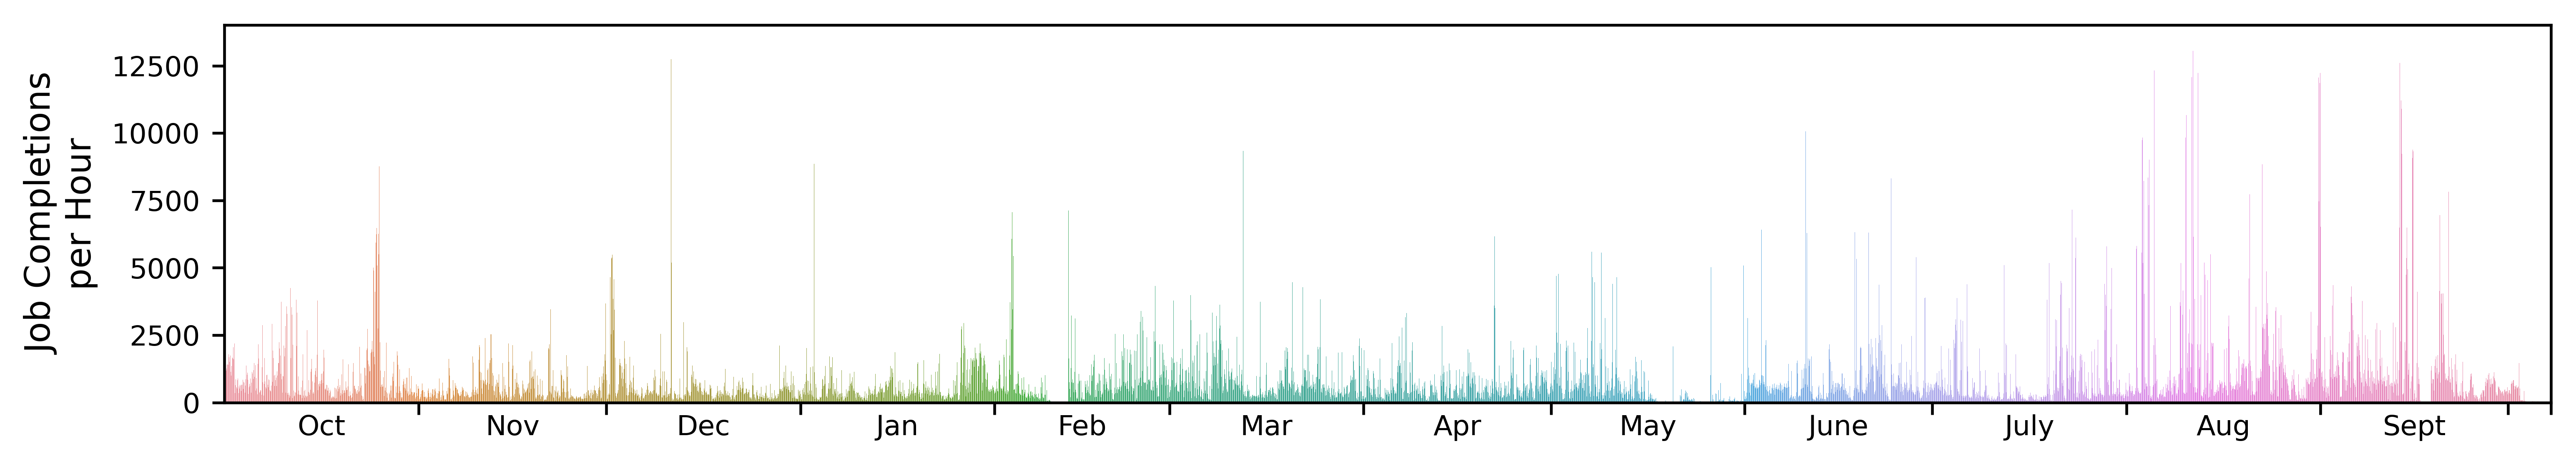

In [14]:
# Plot job completions by hour
fig, ax = plt.subplots(figsize = (12, 2), dpi = 600)

sns.barplot(x = job_completions_by_hour.index, y = 'count', data = job_completions_by_hour)

months = pd.date_range('2020-10','2021-10', freq='MS').strftime('%Y-%m').tolist()
month_intervals = np.cumsum([len(job_completions_by_hour.loc[month]) for month in months]).tolist()
month_label_positions = [round(((a + b) / 2)) for a, b in zip([0] + month_intervals[:-1], month_intervals)]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept']

ax.set_xticks(month_intervals)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(month_label_positions))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(month_labels))
ax.tick_params(which = 'minor', length = 0, labelsize = 8)
ax.tick_params(which = 'major', labelsize = 8)
ax.set_xlabel('')
ax.set_ylabel('Job Completions\nper Hour')

plt.show()

In [15]:
# Create hour and day of week columns
job_completions_by_hour['hour'] = job_completions_by_hour.index.hour
job_completions_by_hour['day_of_week'] = job_completions_by_hour.index.day_of_week

#  Calculate average job completions per hour and day of week
job_completions_by_day_of_week = job_completions_by_hour.groupby(['hour', 'day_of_week'], as_index = False).agg('mean')

# Assign job completion counts from hour 0 to hour 24 to make line plot look connected
job_completions_hour_0 = job_completions_by_day_of_week.loc[job_completions_by_day_of_week['hour'] == 0]
job_completions_by_day_of_week = job_completions_by_day_of_week.append(job_completions_hour_0.assign(hour = 24)).reset_index()

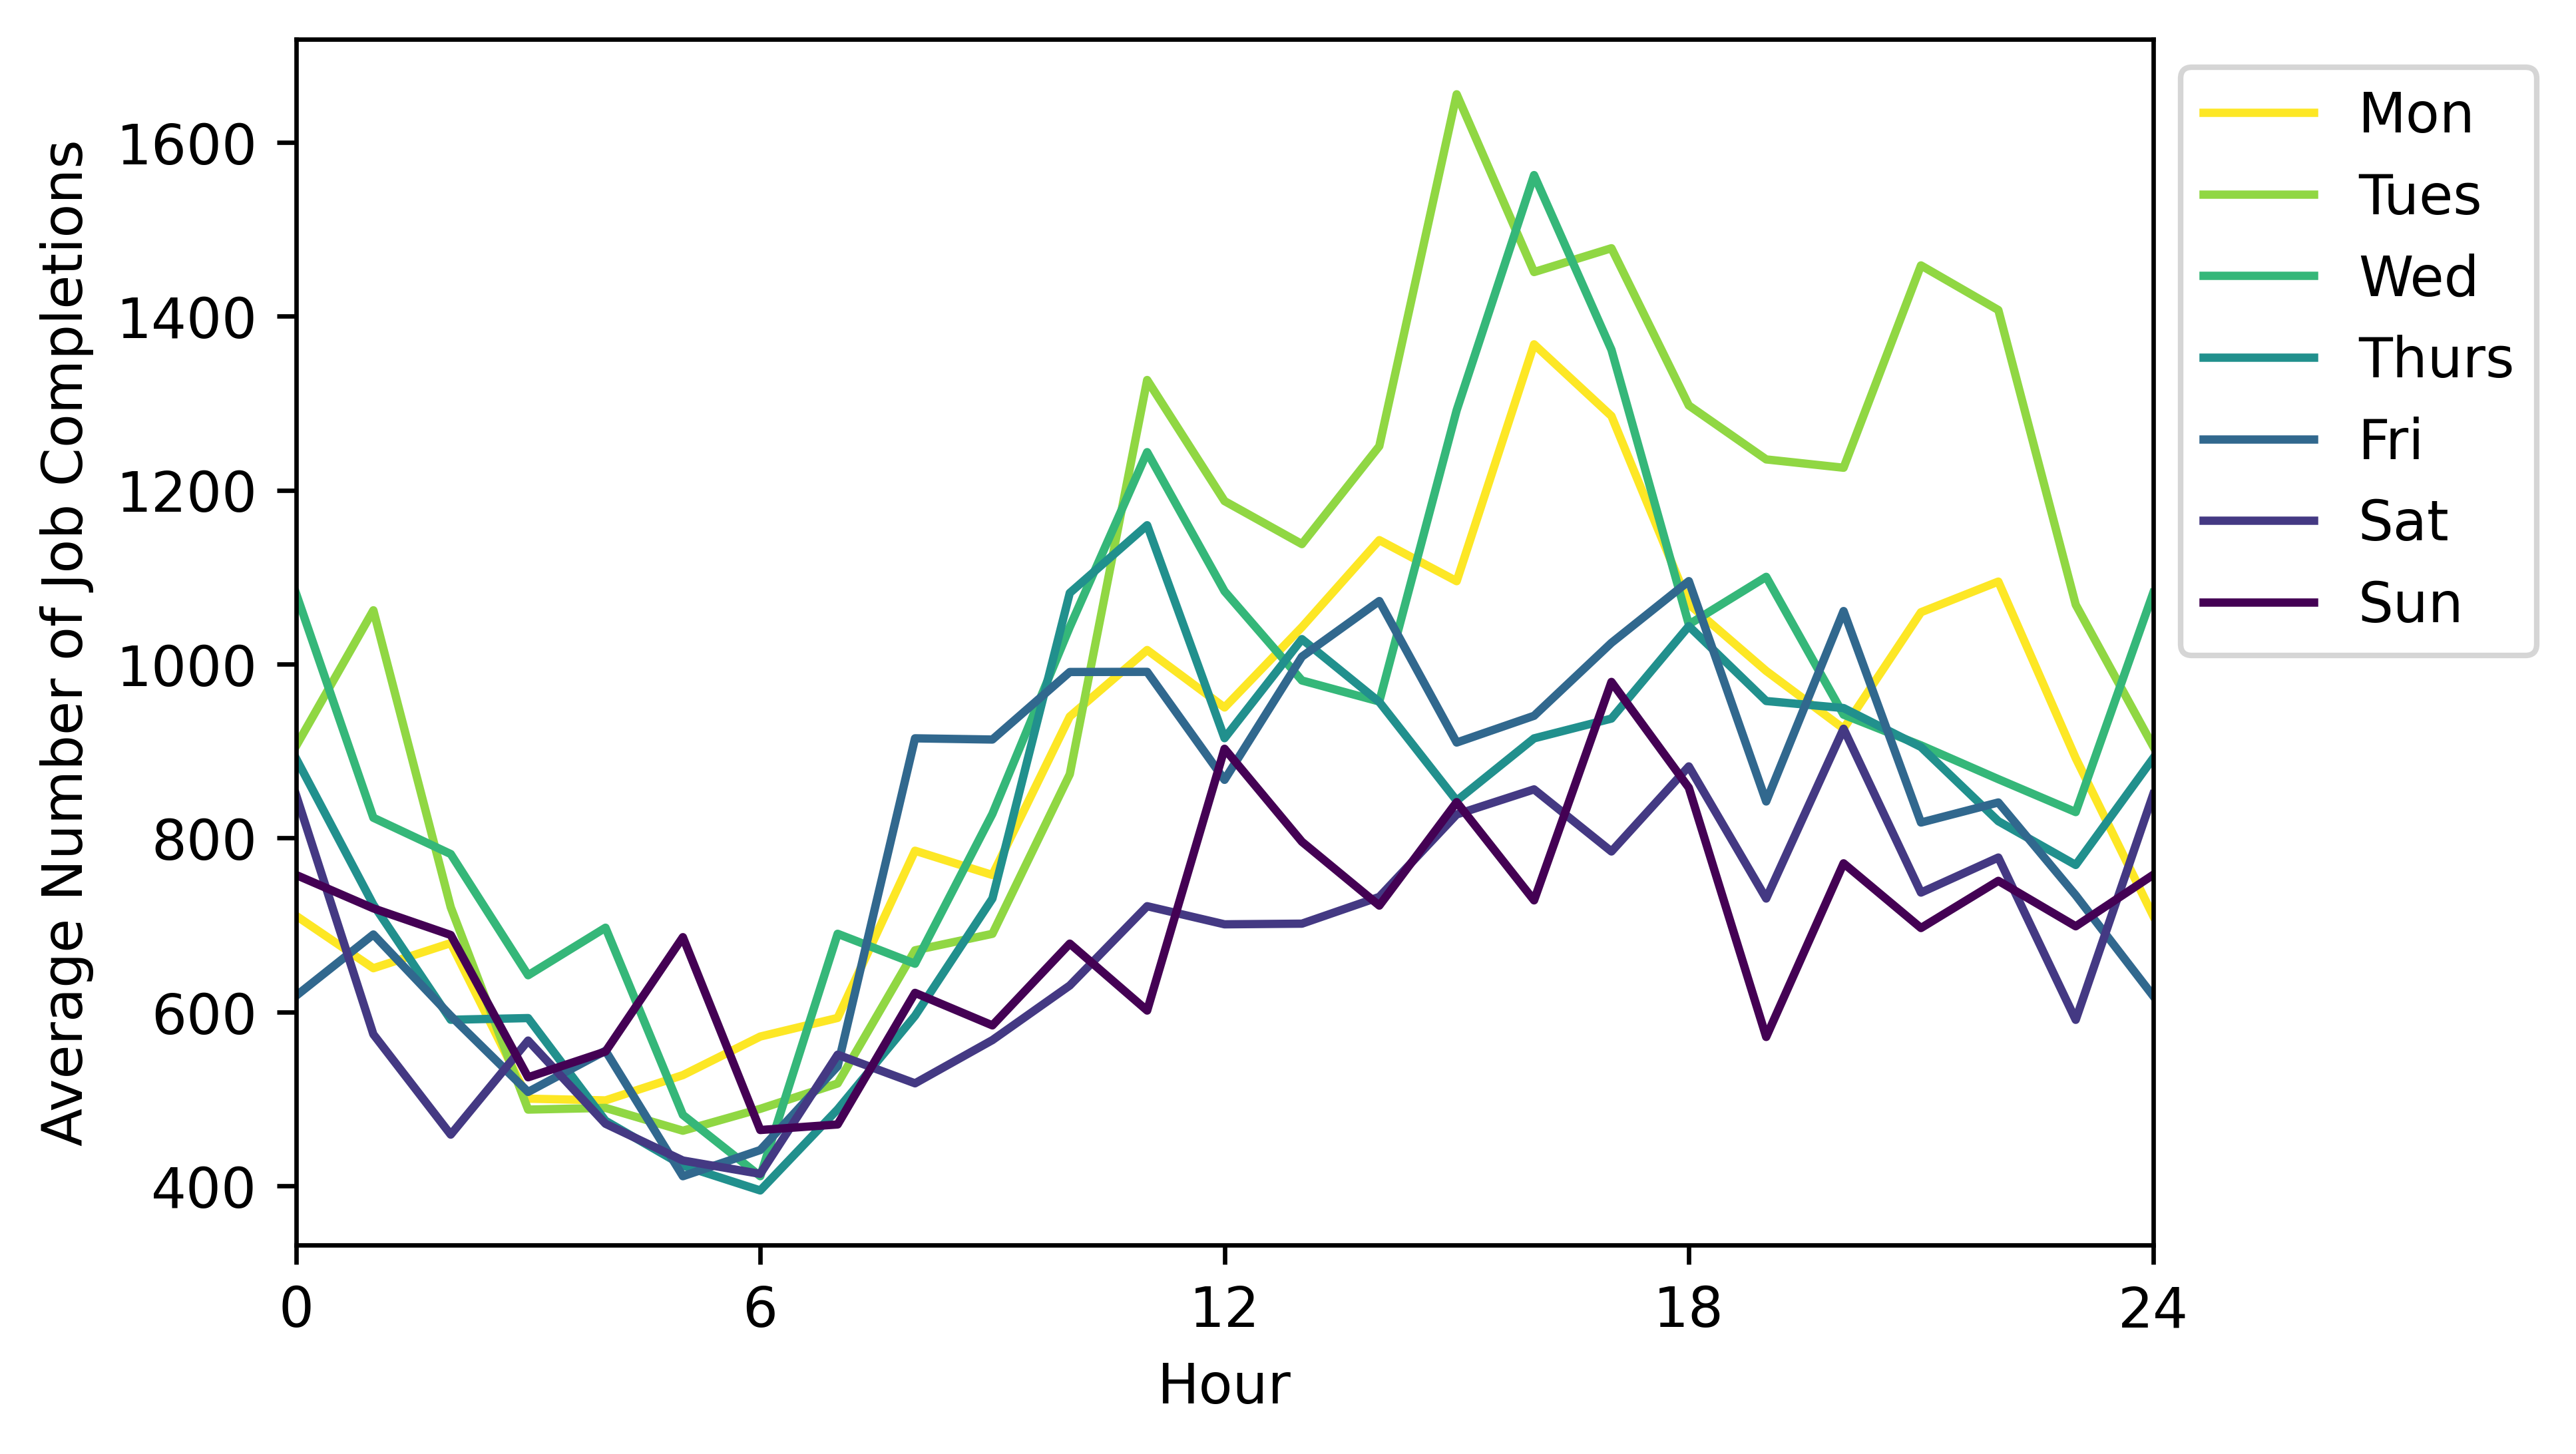

In [16]:
# Plot average job completions per hour and day of week
fig, ax = plt.subplots(figsize = (6, 4), dpi = 600)

sns.lineplot(x = 'hour', y = 'count', data = job_completions_by_day_of_week, hue = 'day_of_week', palette = 'viridis_r')

ax.set_xlim([0, 24])
ax.set_xticks([0, 6, 12, 18, 24])
ax.set_xlabel('Hour')
ax.set_ylabel('Average Number of Job Completions')
ax.legend(title = '', labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], bbox_to_anchor = (1, 1))

plt.show()

In [17]:
# Filter log entries where slurm scheduler was unresponsive (i.e. returncode 1 for squeue commands by user 9204)
ce5_unresponsive_times = list(ce5_log
                             .filter('user = 9204')
                             .filter('returncode = 1')
                             .filter('execution_time > 15')
                             .filter('command = "squeue"')
                             .select(F.date_trunc('hour', F.col('timestamp')).alias('timestamp'))
                             .toPandas()['timestamp']
)

ce6_unresponsive_times = list(ce6_log
                             .filter('user = 9204')
                             .filter('returncode = 1')
                             .filter('execution_time > 15')
                             .filter('command = "squeue"')
                             .select(F.date_trunc('hour', F.col('timestamp')).alias('timestamp'))
                             .toPandas()['timestamp']
)

In [18]:
# Create ce5, ce6, and ce5_ce6 columns showing when ce5 and/or ce6 was unresponsive
job_completions_by_hour['ce5'] = [1 if x in ce5_unresponsive_times else 0 for x in job_completions_by_hour.index.tolist()]
job_completions_by_hour['ce6'] = [1 if x in ce6_unresponsive_times else 0 for x in job_completions_by_hour.index.tolist()]
job_completions_by_hour['ce5_ce6'] = job_completions_by_hour[['ce5', 'ce6']].sum(axis = 1)

# Slice dataframe into weeks for visualization purposes
week_1_job_completions_by_hour = job_completions_by_hour.loc['2021-08-26':'2021-09-01']
week_2_job_completions_by_hour = job_completions_by_hour.loc['2021-09-02':'2021-09-08']
week_3_job_completions_by_hour = job_completions_by_hour.loc['2021-09-09':'2021-09-15']
week_4_job_completions_by_hour = job_completions_by_hour.loc['2021-09-16':'2021-09-22']
week_5_job_completions_by_hour = job_completions_by_hour.loc['2021-09-23':'2021-09-29']
week_6_job_completions_by_hour = job_completions_by_hour.loc['2021-09-30':'2021-10-06']

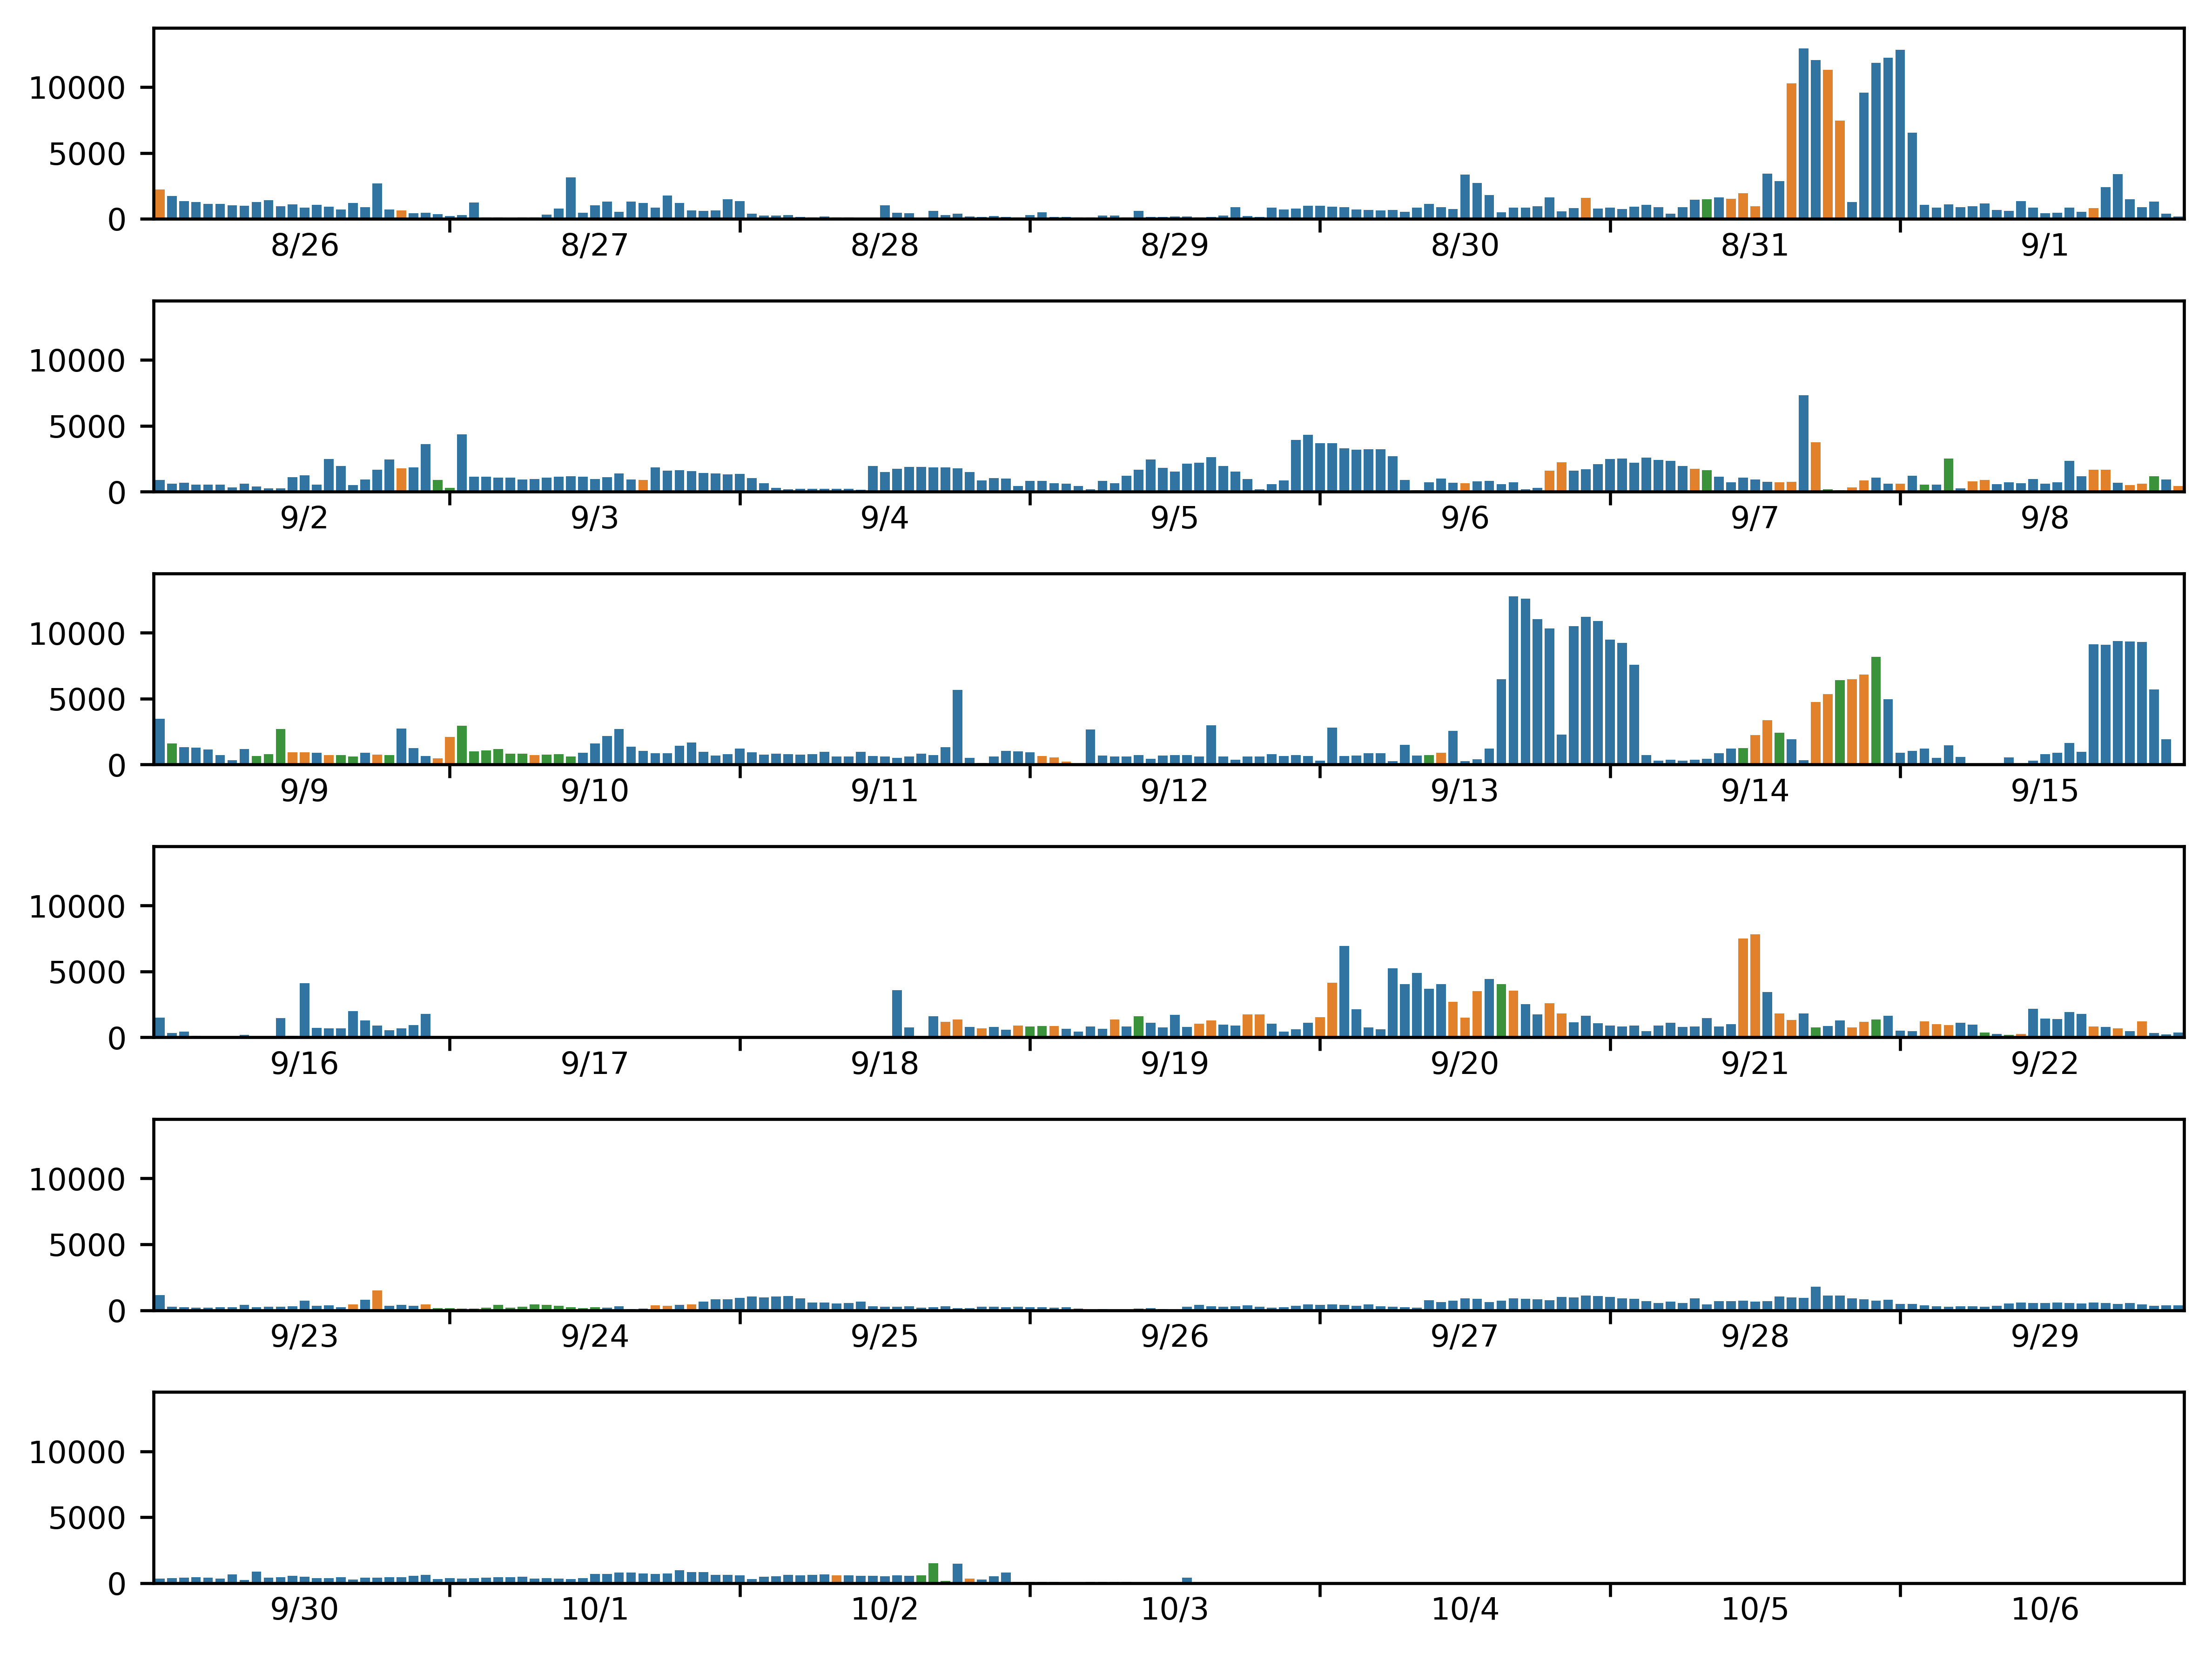

In [19]:
# Plot job completions by hour between aug 26 2021 to oct 6 2021 
fig, axs = plt.subplots(6, 1, figsize = (8, 6), facecolor = 'white', dpi = 600)

sns.barplot(ax = axs[0], x = week_1_job_completions_by_hour.index, y = 'count', data = week_1_job_completions_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[1], x = week_2_job_completions_by_hour.index, y = 'count', data = week_2_job_completions_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[2], x = week_3_job_completions_by_hour.index, y = 'count', data = week_3_job_completions_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[3], x = week_4_job_completions_by_hour.index, y = 'count', data = week_4_job_completions_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[4], x = week_5_job_completions_by_hour.index, y = 'count', data = week_5_job_completions_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[5], x = week_6_job_completions_by_hour.index, y = 'count', data = week_6_job_completions_by_hour, hue = 'ce5_ce6', dodge = False)

day_intervals = [24, 48, 72, 96, 120, 144]
week_label_positions = [12, 36, 60, 84, 108, 132, 156]
days = pd.date_range(start = '2021-08-26', end = '2021-10-06').strftime('%-m/%-d').tolist()
week_labels = [days[i : i + 7] for i in range(0, len(days), 7)]

plt.setp(axs, xticks = day_intervals, xticklabels = [], xlabel = '', ylabel = '', ylim = [0, 14500])
[ax.xaxis.set_major_formatter(ticker.NullFormatter()) for ax in axs]
[ax.xaxis.set_minor_locator(ticker.FixedLocator(week_label_positions)) for ax in axs]
[ax.xaxis.set_minor_formatter(ticker.FixedFormatter(week_label)) for ax, week_label in zip(axs, week_labels)]
[ax.tick_params(which = 'minor', length = 0, labelsize = 8) for ax in axs]
[ax.tick_params(which = 'major', labelsize = 8) for ax in axs]
[ax.yaxis.offsetText.set_fontsize(6) for ax in axs]
[ax.get_legend().remove() for ax in axs]

fig.tight_layout(pad = 1)

plt.show()

In [20]:
# Aggregate memory unloaded by hour
memory_unloaded_by_hour = (slurm_jobs
                          .groupBy(F.date_trunc('hour', F.col('END')).alias('timestamp'))
                          .agg(F.sum('REQMEM').alias('REQMEM'))
                          .sort('timestamp')
                          .toPandas()
                          .set_index('timestamp')
)

In [21]:
# Create ce5, ce6, and ce5_ce6 columns showing when ce5 and/or ce6 was unresponsive
memory_unloaded_by_hour['ce5'] = [1 if x in ce5_unresponsive_times else 0 for x in memory_unloaded_by_hour.index.tolist()]
memory_unloaded_by_hour['ce6'] = [1 if x in ce6_unresponsive_times else 0 for x in memory_unloaded_by_hour.index.tolist()]
memory_unloaded_by_hour['ce5_ce6'] = memory_unloaded_by_hour[['ce5', 'ce6']].sum(axis = 1)

# Slice dataframe into weeks for visualization purposes
week_1_memory_unloaded_by_hour = memory_unloaded_by_hour.loc['2021-08-26':'2021-09-01']
week_2_memory_unloaded_by_hour = memory_unloaded_by_hour.loc['2021-09-02':'2021-09-08']
week_3_memory_unloaded_by_hour = memory_unloaded_by_hour.loc['2021-09-09':'2021-09-15']
week_4_memory_unloaded_by_hour = memory_unloaded_by_hour.loc['2021-09-16':'2021-09-22']
week_5_memory_unloaded_by_hour = memory_unloaded_by_hour.loc['2021-09-23':'2021-09-29']
week_6_memory_unloaded_by_hour = memory_unloaded_by_hour.loc['2021-09-30':'2021-10-06']

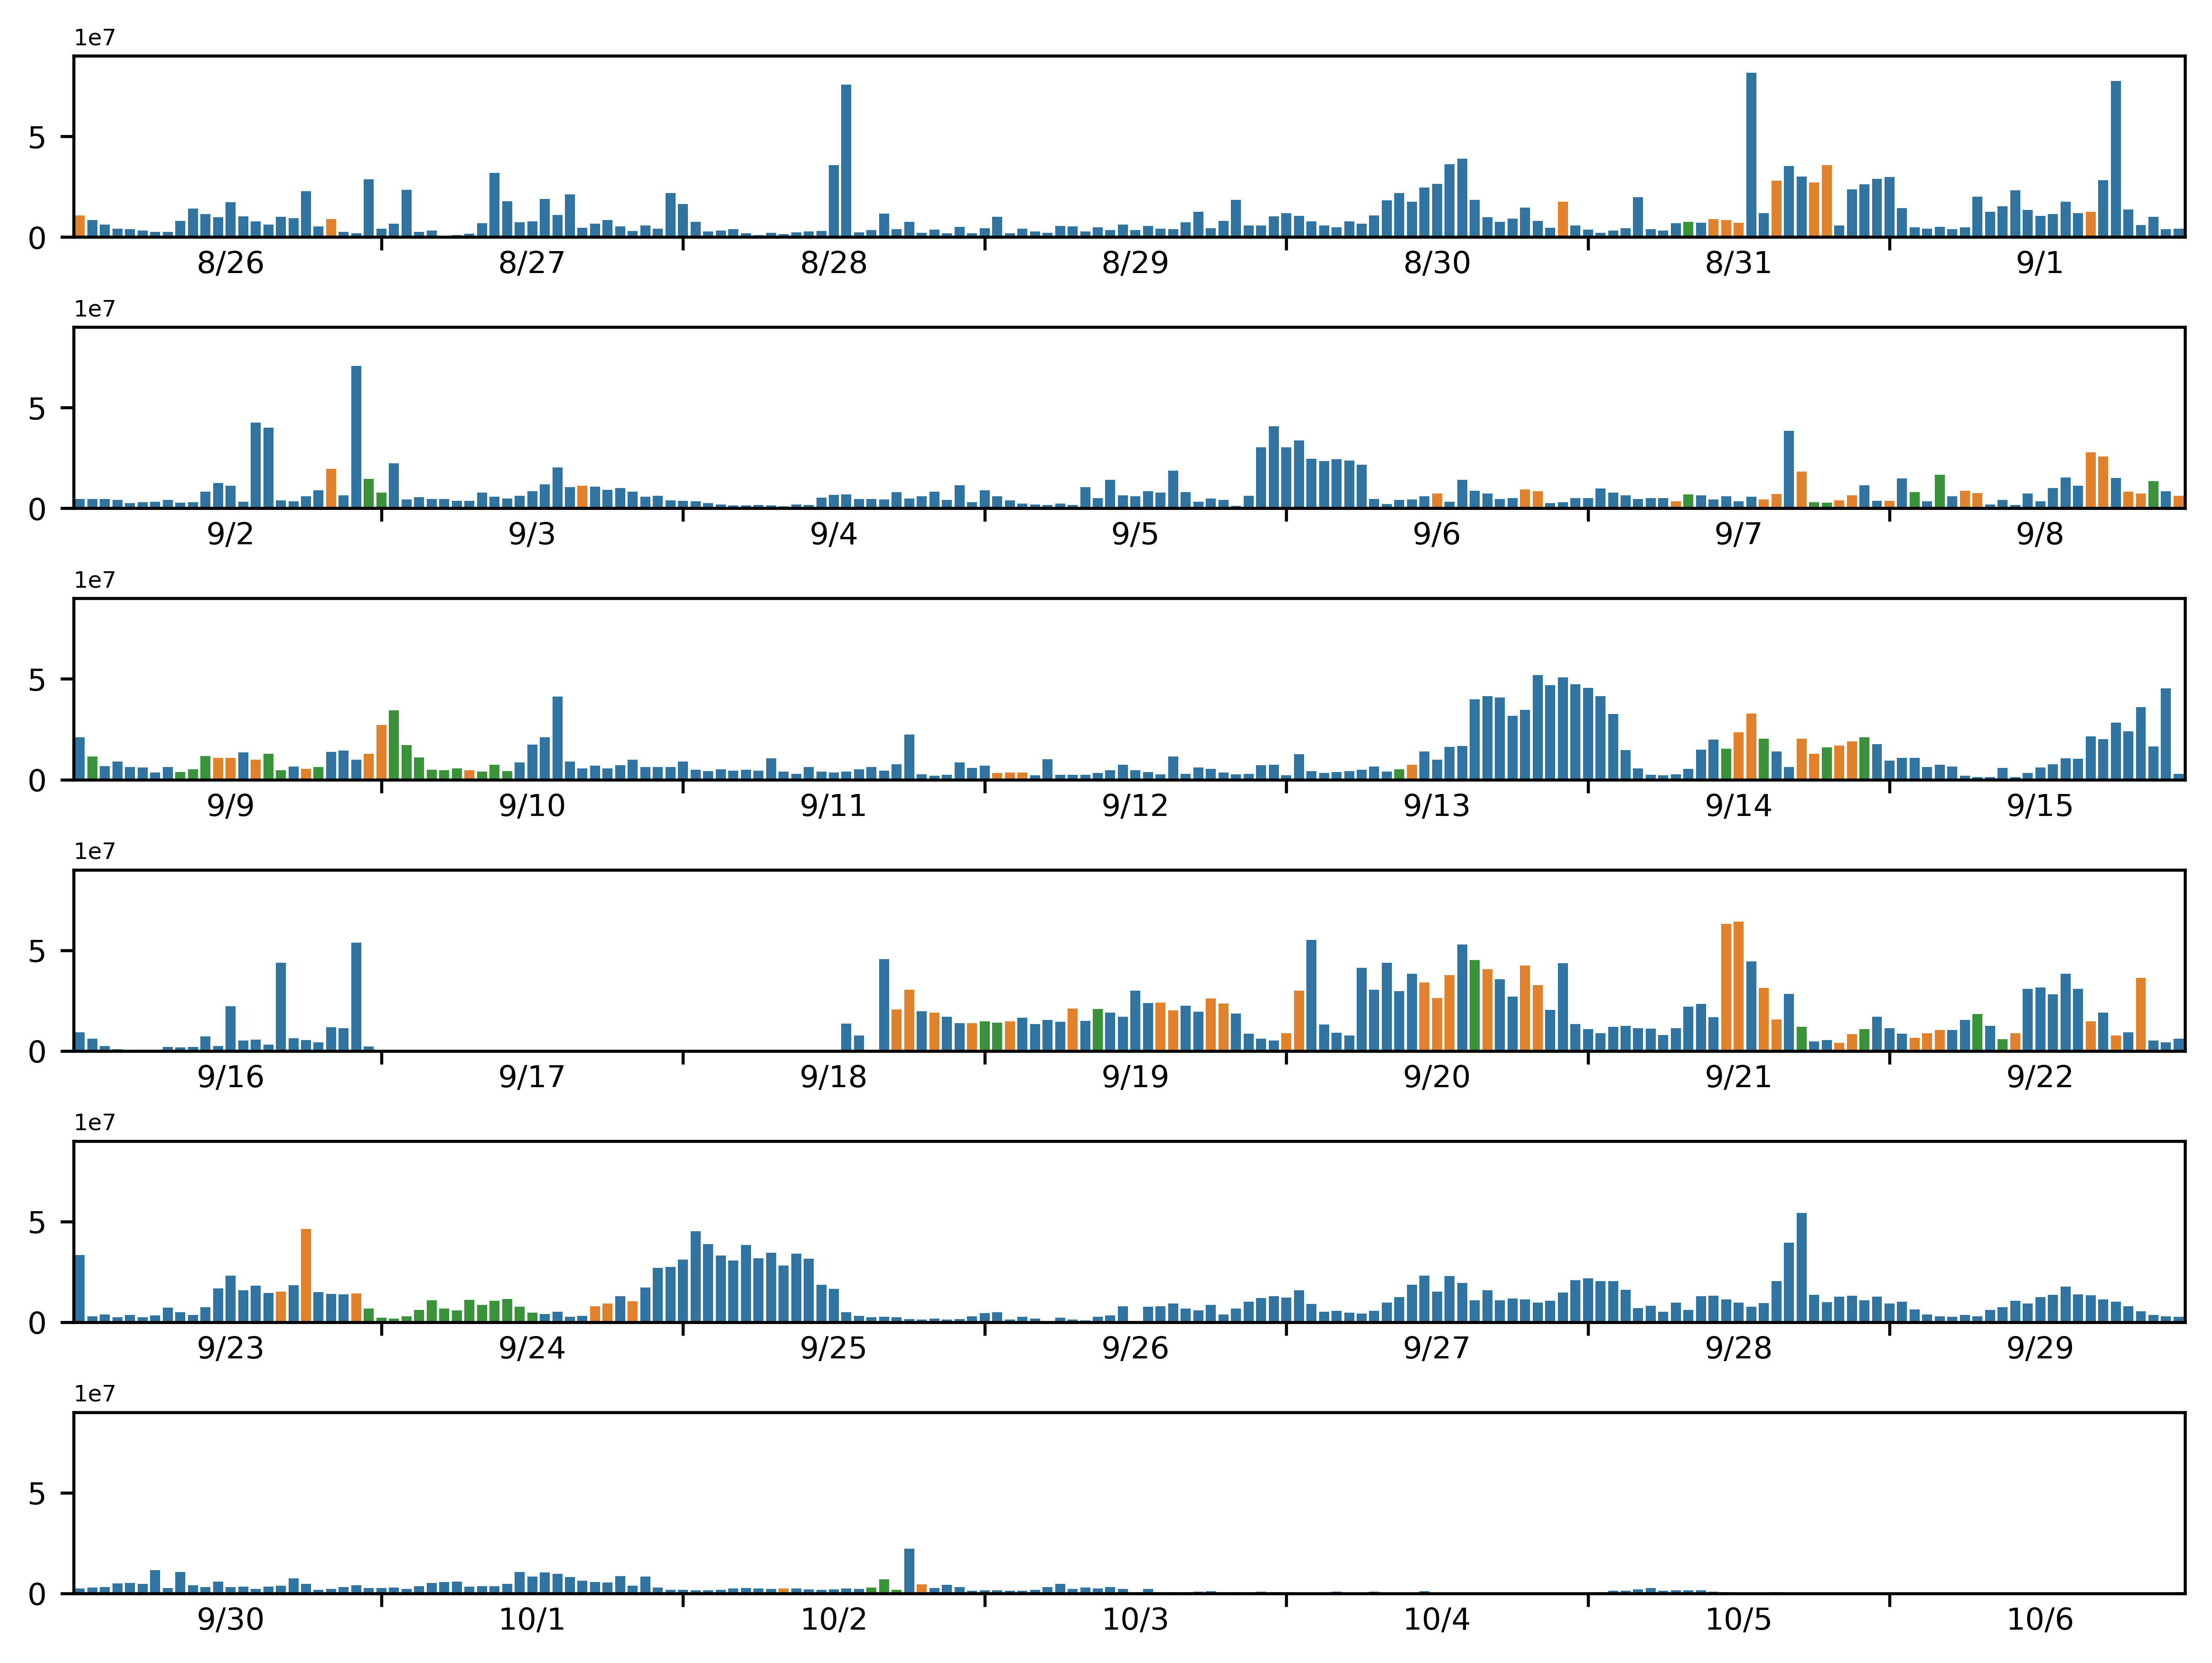

In [22]:
# Plot memory unloaded by hour between aug 26 2021 to oct 6 2021 
fig, axs = plt.subplots(6, 1, figsize = (8, 6), facecolor = 'white', dpi = 600)

sns.barplot(ax = axs[0], x = week_1_memory_unloaded_by_hour.index, y = 'REQMEM', data = week_1_memory_unloaded_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[1], x = week_2_memory_unloaded_by_hour.index, y = 'REQMEM', data = week_2_memory_unloaded_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[2], x = week_3_memory_unloaded_by_hour.index, y = 'REQMEM', data = week_3_memory_unloaded_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[3], x = week_4_memory_unloaded_by_hour.index, y = 'REQMEM', data = week_4_memory_unloaded_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[4], x = week_5_memory_unloaded_by_hour.index, y = 'REQMEM', data = week_5_memory_unloaded_by_hour, hue = 'ce5_ce6', dodge = False)
sns.barplot(ax = axs[5], x = week_6_memory_unloaded_by_hour.index, y = 'REQMEM', data = week_6_memory_unloaded_by_hour, hue = 'ce5_ce6', dodge = False)

day_intervals = [24, 48, 72, 96, 120, 144]
week_label_positions = [12, 36, 60, 84, 108, 132, 156]
days = pd.date_range(start = '2021-08-26', end = '2021-10-06').strftime('%-m/%-d').tolist()
week_labels = [days[i : i + 7] for i in range(0, len(days), 7)]

plt.setp(axs, xticks = day_intervals, xticklabels = [], xlabel = '', ylabel = '', ylim = [0, 90000000])
[ax.xaxis.set_major_formatter(ticker.NullFormatter()) for ax in axs]
[ax.xaxis.set_minor_locator(ticker.FixedLocator(week_label_positions)) for ax in axs]
[ax.xaxis.set_minor_formatter(ticker.FixedFormatter(week_label)) for ax, week_label in zip(axs, week_labels)]
[ax.tick_params(which = 'minor', length = 0, labelsize = 8) for ax in axs]
[ax.tick_params(which = 'major', labelsize = 8) for ax in axs]
[ax.yaxis.offsetText.set_fontsize(6) for ax in axs]
[ax.get_legend().remove() for ax in axs]

fig.tight_layout(pad = 0.5)

plt.show()